In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import pandas as pd
import os, glob, imageio
import numpy as np
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

from dataset.kernel_image_pair import KernelImagePair, default_augmentations, default_transforms
from network.sftmd import SFTMD, Predictor, Corrector

In [2]:
import numpy as np
import math
from torchvision.utils import make_grid
def tensor2img(tensor, out_type=np.uint8, min_max=(0, 1)):
    '''
    Converts a torch Tensor into an image Numpy array
    Input: 4D(B,(3/1),H,W), 3D(C,H,W), or 2D(H,W), any range, RGB channel order
    Output: 3D(H,W,C) or 2D(H,W), [0,255], np.uint8 (default)
    '''
    tensor = tensor.squeeze().float().cpu().clamp_(*min_max)  # clamp
    tensor = (tensor - min_max[0]) / (min_max[1] - min_max[0])  # to range [0,1]
    n_dim = tensor.dim()
    if n_dim == 4:
        n_img = len(tensor)
        img_np = make_grid(tensor, padding=0, nrow=1, normalize=False).numpy()
        img_np = np.transpose(img_np[[2, 1, 0], :, :], (1, 2, 0))  # HWC, BGR
    elif n_dim == 3:
        img_np = tensor.numpy()
        img_np = np.transpose(img_np[[2, 1, 0], :, :], (1, 2, 0))  # HWC, BGR
    elif n_dim == 2:
        img_np = tensor.numpy()
    else:
        raise TypeError(
            'Only support 4D, 3D and 2D tensor. But received with dimension: {:d}'.format(n_dim))
    if out_type == np.uint8:
        img_np = (img_np * 255.0).round()
        # Important. Unlike matlab, numpy.unit8() WILL NOT round by default.
    return img_np.astype(out_type)

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [7]:
train_imgs = glob.glob("../data/DIV2K/DIV2K_train_HR/**/*.png", recursive=True)
test_imgs = glob.glob("../data/DIV2K/DIV2K_valid_HR/**/*.png", recursive=True)
scale=4
ker_dim=10
aniso=False
diverse=False
train_kernel = f"kernels/train/kernel_scale{scale}_{'aniso' if aniso else 'iso'}_dim{ker_dim}{'_diverse' if diverse else ''}.pth"
test_kernel = f"kernels/test_2/kernel_scale{scale}_{'aniso' if aniso else 'iso'}_dim{ker_dim}{'_diverse' if diverse else ''}.pth"


testsets = dict(
    set5=glob.glob("../data/testing_datasets/Set5/*.png", recursive=True),
    div2k=glob.glob("../data/DIV2K/DIV2K_valid_HR/*.png", recursive=True),
#     set14=glob.glob("../data/testing_datasets/Set14/*.png", recursive=True),
    set14=glob.glob("../data/set14/Set14/images/*.png", recursive=True),
    urban100=glob.glob("../data/testing_datasets/Urban100/*.png", recursive=True),
    ffhq=glob.glob("../../ffhq-dataset/data/images1024x1024_test/69000/*.png", recursive=True)
)
batch_size=1

In [8]:
dataset = KernelImagePair(imgs=testsets['set5'], 
                            kernel_pickle=test_kernel, scale=scale, 
                            augmentations=default_augmentations, transforms=default_transforms, 
                            seed=0, train=False, cubic=True, interpolation="nearest")
dl = DataLoader(dataset)
def image_to_bd(img, preserve_lr=False, cuda=True):
    # img : tensor(CHW), np.array(HWC) 
    dataset.imgs = [img]
    ds = next(iter(dl))
    if preserve_lr:
        ds['LR'] = ds['HR']
    if cuda:
        with torch.no_grad():
            for k, v in ds.items():
                ds[k] = ds[k].cuda()
    return ds

In [9]:
def psnr(est, gt, is_rgb=True):
    diff = est - gt
    shave = scale
    if diff.size(1) > 1 and not is_rgb:
        gray_coeffs = [65.738, 129.057, 25.064]
        convert = diff.new_tensor(gray_coeffs).view(1, 3, 1, 1) / 256
        diff = diff.mul(convert).sum(dim=1)
    valid = diff[..., shave:-shave, shave:-shave]
    mse = valid.pow(2).mean()
    # 20 * torch.log10(1/(diff))
    return -10 * torch.log10(mse)

In [11]:
sr =  '/home/choijongho/workspace/sang/ikc_synthetic/butterfly.png'
hr = '/home/choijongho/synthetic_lrs/original/butterfly.png'
def psnr_img_path(sr, hr):
    sr = imageio.imread(sr)
    sr = sr.transpose((2, 0, 1))
    sr = torch.from_numpy(sr).unsqueeze(0).float() / 255
    hr = imageio.imread(hr)
    hr = hr.transpose((2, 0, 1))
    hr = torch.from_numpy(hr).unsqueeze(0).float() / 255
    return psnr(sr, hr, is_rgb=False).item()

In [12]:
sr_edsr =  '/home/choijongho/workspace/sang/synthetic_set14/img_001_SRF_4_HR_x4_SR.png'
sr_ikc = '/home/choijongho/workspace/ikc/set14/img_001_SRF_4_HR.png'
hr = "/home/choijongho/workspace/sisr/data/set14/Set14/images/img_001_SRF_4_HR.png"
print(psnr_img_path(sr_edsr, hr))
print(psnr_img_path(sr_ikc, hr))
# sr =  '/home/choijongho/workspace/ikc/butterfly.png'
# print(psnr_img_path(sr, hr))

21.72319221496582
22.68343162536621


In [13]:
srs = sorted(glob.glob("/home/choijongho/test/sr/*.png"))
hrs = sorted(glob.glob("/home/choijongho/test/hr/*.png"))

psnrs = []
for i in range(5):
    sr = imageio.imread(srs[i])
    sr = sr.transpose((2, 0, 1))
    sr = torch.from_numpy(sr).unsqueeze(0).float() / 255
    hr = imageio.imread(hrs[i])
    hr = hr.transpose((2, 0, 1))
    hr = torch.from_numpy(hr).unsqueeze(0).float() / 255
    psnrs.append(psnr(sr, hr, is_rgb=False))
    
print(sum(psnrs) / 5)
print(psnrs)

tensor(32.2880)
[tensor(33.7877), tensor(35.1845), tensor(28.7711), tensor(33.0057), tensor(30.6908)]


In [10]:
def image_to_LR(img, seed=None):
    if seed is not None:
        dataset.random = np.random.RandomState(seed)
    bd = image_to_bd(img)
    lr = Image.fromarray(tensor2img(bd['LR']))
    return lr

In [19]:
def save_dataset(imgs, destination="test_imgs/"):
    os.makedirs(destination + "/lr/", exist_ok=True)
    os.makedirs(destination + "/hr/", exist_ok=True)
    os.makedirs(destination + "/k/", exist_ok=True)
    dataset.random = np.random.RandomState(1)
    for img in imgs:
        bd = image_to_bd(img, cuda=False)
        lr = Image.fromarray(tensor2img(bd['LR']))
        lr.save(os.path.join(destination + "/lr/", os.path.basename(img)))
        pil = Image.open(img)
        pil.save(os.path.join(destination + "/hr/", os.path.basename(img)))
        k = bd['k'][0]

#         plt.imshow(k.numpy())
#         plt.show()
        torch.save(k, os.path.join(destination + "/k/", os.path.basename(img)))

In [20]:
save_dataset(testsets['set5'], "test_imgs/set5/iso/")

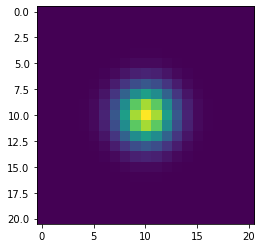

In [22]:
k = torch.load("test_imgs/set5/iso/k/butterfly.png")
plt.add_sub
plt.imshow(k.numpy())